UNet: https://github.com/milesial/Pytorch-UNet

UNet for MRI: https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/

## Import modules and set pytorch device

In [1]:
import os
import sys
import time
import warnings
import pathlib
import random
import pickle
from tqdm import tqdm

# science
import numpy as np
import pandas as pd
import scipy as sp

# for neural data
import mne
import nilearn
from scipy import signal, stats

# for reading this dataset (paper with neural nets classification movement vs no-movement)
#from scipy.io import netcdf
#import xarray as xr

# for plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

# prosto dunul
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#!pip install torchsummary
from torchsummary import summary

sns.set_context('notebook', font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('muted')

### Set device

In [2]:
def set_device():
    """
    Set the device. CUDA if available, CPU otherwise

    Args:
    None

    Returns:
    Nothing
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    if device != "cuda":
        print("WARNING: For this notebook to perform best, "
            "if possible, in the menu under `Runtime` -> "
            "`Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device

DEVICE = set_device()

GPU is enabled in this notebook.


### Set hyperparams

In [4]:
args = {'n_epochs': 200,
        'batch_size': 16,
        'device': DEVICE, 
        'lr': 1e-3, 
        'momentum': 0.9, 
        'lambda_l1': 0, 
        'lambda_l2': 0}

# optimizer
# loss_fn

## Load data

In [3]:
data_path = r"D:\data_nma2022\tfr data"

fname_data = "power-roi-all-patients.npy"
fpath_data = os.path.join(data_path, fname_data)

fname_mdata = "power-roi-all-patients-metadata.csv"
fpath_mdata = os.path.join(data_path, fname_mdata)

print("1. Getting data ...")
print(f"Reading {fname_data}...")
data = np.load(fpath_data)[:, :, :, 35:65]

print(f"Data shape: {data.shape} = (n_samples, n_chan, n_freqs, n_times)")
n_samples, n_chan, n_freqs, n_times = data.shape

print("2. Getting metadata ...")
print(f"Reading {fname_mdata}...")
metadata = pd.read_csv(fpath_mdata, index_col=0)
metadata.head()

1. Getting data ...
Reading power-roi-all-patients.npy...
Data shape: (5984, 8, 25, 30) = (n_samples, n_chan, n_freqs, n_times)
2. Getting metadata ...
Reading power-roi-all-patients-metadata.csv...


,day,time,event_timestamp,mvmt,vid_name,event_frame_idx,false_pos,patient_id,I_over_C_ratio,r_wrist_x,...,l_wrist_y,audio_ratio,reach_duration,reach_r,reach_a,onset_velocity,other_reach_overlap,bimanual,other_lead_lag,patient_index
0,3,3520224,3520224,r_wrist,a0f66459_5_0500.avi,2206,0,a0f66459,0.029668,"[292.4933419228, 292.4933419228, 292.493341922...",...,"[211.6673732102, 211.6988453865, 211.667373210...",0.173995,29,56.068108,-152.360333,3.133708,0,0,NaN,0
1,3,3584342,3584342,r_wrist,a0f66459_5_0501.avi,536,0,a0f66459,0.005848,"[288.1831774712, 288.1836948395, 288.183694839...",...,"[208.3187561035, 208.3187561035, 208.318756103...",0.185332,29,120.020850,-103.292387,5.215469,0,0,NaN,0
2,3,28768352,28768352,r_wrist,a0f66459_5_0711.avi,73,0,a0f66459,0.039133,"[277.4298783541, 277.6194574833, 277.619457483...",...,"[221.6612606049, 221.6737040281, 221.794342160...",0.365911,41,37.482779,147.428994,3.061077,0,0,NaN,0
3,3,28853918,28853918,r_wrist,a0f66459_5_0711.avi,2640,0,a0f66459,0.030491,"[279.3920893669, 279.3920893669, 279.392089366...",...,"[222.3323924541, 222.3482117653, 222.35734725,...",0.501548,19,35.601992,-122.635080,2.163772,0,0,NaN,0
4,3,29639049,29639049,r_wrist,a0f66459_6_0000.avi,674,0,a0f66459,0.454378,"[252.2575044632, 252.2575044632, 252.257504463...",...,"[228.3691136539, 228.3421618044, 228.038380678...",0.238979,24,94.181709,-56.404814,5.021071,19,1,3.0,0


## Train-test split

### Within-subject test-split (leave one day out - LODO)

In [4]:
days = metadata.day.values
labels = metadata.reach_a.values

test_day = 3

mask_train = (days != test_day)
mask_test  = (days == test_day)

X_train, y_train = data[mask_train], np.array(labels[mask_train])
X_test,  y_test  = data[mask_test],  np.array(labels[mask_test])

print(f" X_train: {X_train.shape} \n X_test:  {X_test.shape} \n y_train: {y_train.shape} \n y_test:  {y_test.shape} ")

# creating torch tensors (batch size is variable, so we will create data loader in run_nn func)

X_train_lodo = torch.tensor(X_train).float()
X_test_lodo = torch.tensor(X_test).float()

y_train_lodo = torch.tensor(y_train).float()
y_test_lodo = torch.tensor(y_test).float()

 X_train: (4835, 8, 25, 30) 
 X_test:  (1149, 8, 25, 30) 
 y_train: (4835,) 
 y_test:  (1149,) 


### Between-subject test-split (leave one subject out - LOSO)

In [5]:
labels = metadata.reach_a.values
patients = metadata.patient_index

test_sbj_1 = 4
test_sbj_2 = 5  # total of 203 + 860 trials


mask_train = (patients != test_sbj_1) & (patients != test_sbj_2)
mask_test  = (patients == test_sbj_1) | (patients == test_sbj_2)

X_train, y_train = data[mask_train], np.array(labels[mask_train])
X_test,  y_test  = data[mask_test],  np.array(labels[mask_test])

print(f" X_train: {X_train.shape} \n X_test:  {X_test.shape} \n y_train: {y_train.shape} \n y_test:  {y_test.shape} ")

# creating data loaders

X_train_loso = torch.tensor(X_train).float()
X_test_loso = torch.tensor(X_test).float()

y_train_loso = torch.tensor(y_train).float()
y_test_loso = torch.tensor(y_test).float()

# train_loader_lodo = DataLoader(list(zip(X_train, y_train)),
#                           batch_size=args['batch_size'],
#                           shuffle=True)

# test_loader_lodo = DataLoader(list(zip(X_test, y_test)),
#                          batch_size=args['batch_size'],
#                          shuffle=True)

print(f" X_train: {X_train.shape} \n X_test:  {X_test.shape} \n y_train: {y_train.shape} \n y_test:  {y_test.shape} ")

 X_train: (4912, 8, 25, 30) 
 X_test:  (1072, 8, 25, 30) 
 y_train: (4912,) 
 y_test:  (1072,) 
 X_train: (4912, 8, 25, 30) 
 X_test:  (1072, 8, 25, 30) 
 y_train: (4912,) 
 y_test:  (1072,) 


## Define model

### Helper modules

In [6]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


### Main EcogUNet module

In [16]:
class EcogUNet(nn.Module):
    
    def __init__(self, n_channels, n_freqs, n_times, bilinear=False):
        super(EcogUNet, self).__init__()
        self.n_channels = n_channels
        self.n_freqs = n_freqs
        self.n_times = n_times
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1

        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
        # at this point we have vector of shape (batch_size, 64, n_freqs, n_times)
        
        # reduce the shape of input by // 2 and channels by 2
        self.down5 = Down(64, 32)
        
        self.flatten = nn.Flatten()
        
        # get shape (batch_size, 32 * n_freqs // 2 * n_times // 2)
        
        self.fc1 = nn.Linear(32 * (n_freqs // 2) * (n_times // 2), 512)
        self.act1 = nn.SiLU()
        self.dropout = nn.Dropout(p=0.3)
        
        self.fc2 = nn.Linear(512, 256)
        self.act2 = nn.SiLU()
        # self.batchnorm = nn.BatchNorm1d(256)
        
        self.output = nn.Linear(256, 2)
        self.out_act = nn.Hardtanh(-1., 1.)
           

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        x = self.up2(x4, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        # returned to original shape and 64 channels
        x = self.down5(x)
        x = self.flatten(x)
        # FC 1 
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout(x)
        # FC 2
        x = self.fc2(x)
        x = self.act2(x)
        #x = self.batchnorm(x)
        # output layer [-1, 1]
        x = self.output(x)
        out = self.out_act(x)
        return out


In [17]:
summary(EcogUNet(n_chan, n_freqs, n_times).to(DEVICE), (n_chan, n_freqs, n_times))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 25, 30]           4,608
       BatchNorm2d-2           [-1, 64, 25, 30]             128
              ReLU-3           [-1, 64, 25, 30]               0
            Conv2d-4           [-1, 64, 25, 30]          36,864
       BatchNorm2d-5           [-1, 64, 25, 30]             128
              ReLU-6           [-1, 64, 25, 30]               0
        DoubleConv-7           [-1, 64, 25, 30]               0
         MaxPool2d-8           [-1, 64, 12, 15]               0
            Conv2d-9          [-1, 128, 12, 15]          73,728
      BatchNorm2d-10          [-1, 128, 12, 15]             256
             ReLU-11          [-1, 128, 12, 15]               0
           Conv2d-12          [-1, 128, 12, 15]         147,456
      BatchNorm2d-13          [-1, 128, 12, 15]             256
             ReLU-14          [-1, 128,

## Defining train, test and run funcs

In [18]:
def train_nn(args, model, train_loader, optimizer, criterion):
    """
    Traines the model for one epoch
    Returns the trained model
    
    """
    device = args['device']
    
    model.train()
    model.to(device)
    
    for batch_idx, (X, y) in enumerate(train_loader):
        
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        # criterion is MSE loss, however it is done on sin and cos of real angle!!!!
        angle = y / 180 * np.pi
        
        label = torch.cat((torch.sin(angle).unsqueeze(1), torch.cos(angle).unsqueeze(1)), dim=1)
        prediction = model(X)
    
        loss = criterion(label, prediction)
        
        # regularization
        if args['lambda_l1'] != 0:
            l1_loss = sum([torch.sum(torch.abs(p)) for p in model.parameters()])
            loss = loss + args['lambda_l1'] * l1_loss
        if args['lambda_l2'] != 0:
            l2_loss = sum([torch.sum(p.pow(2)) for p in model.parameters()])
            loss = loss + args['lambda_l2'] * l2_loss

        loss.backward()
        optimizer.step()
        
    return model


def test_nn(args, model, test_loader, criterion):
    """
    Calculates one epoch loss and accuracy
    
    """
    device = args['device']
    
    model.eval()
    model.to(device)
    
    mse_loss = 0
    angle_loss = 0
    
    with torch.no_grad():
        for X, y in test_loader:
            
            X, y = X.to(device), y.to(device)
            
            angle = y / 180 * np.pi
        
            label = torch.cat((torch.sin(angle).unsqueeze(1), torch.cos(angle).unsqueeze(1)), dim=1)
            prediction = model(X)
            
            assert prediction.shape == label.shape
            mse_loss += criterion(prediction, label, reduction='sum')
            
            predicted_angle = torch.atan2(prediction[:, 0], prediction[:, 1])
            
            # mean absolute deviation in degrees
            assert predicted_angle.shape == angle.shape
            angle_loss += torch.sum((torch.abs(predicted_angle - angle) / np.pi * 180) % 180)
            
            
        # acquire per-sample loss    
        mse_loss /= len(test_loader.dataset)
        angle_loss /= len(test_loader.dataset)
        
         
    return mse_loss, angle_loss
    
    
def run_nn(args, model, X_train, X_test, y_train, y_test, outputs_liveloss=[MatplotlibPlot()], run_id='01', save_frequency=5):
    """
    Trains the model with train_loader and
    tests the learned model using val_loader

    Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Train dataset
    test_loader: torch.loader
      Validation set

    Returns:
    test_acc_list: list
      Log of validation accuracy
    train_acc_list: list
      Log of training accuracy
    trained_model: nn.module
      Trained model/model post training
    """
    
    # create DataLoaders
    train_loader = DataLoader(list(zip(X_train, y_train)), 
                                   batch_size=args['batch_size'], 
                                   shuffle=True)

    test_loader  = DataLoader(list(zip(X_test, y_test)), 
                                   batch_size=args['batch_size'],
                                   shuffle=True)

    print(f" X_train: {X_train.shape} \n X_test:  {X_test.shape} \n y_train: {y_train.shape} \n y_test:  {y_test.shape} ")

    device = args['device']
    model = model.to(device)
    
    # may tune it to RMSprop as in original github
    #optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
    optimizer = optim.RMSprop(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'], momentum=args['momentum'])
    
    # from stackoverflow: 0.5 (sin(angle) - sin_hat)**2 + (cos(angle) - cos_hat) ** 2) = MSE!!!
    criterion = F.mse_loss
        
    # for live loss update plotting
    groups = {'MSE, a.u.': ['mse-train', 'mse-test'], 'Angle Absolute Difference, degrees': ['angle-diff-train', 'angle-diff-test']}
    plotlosses = PlotLosses(groups=groups, outputs=outputs_liveloss)
    
    # initialize loss containers
    train_mse_loss_list, test_mse_loss_list, train_angle_loss_list, test_angle_loss_list = [], [], [], []
    trained_model = model
    

    # main training loop
    for epoch in tqdm(range(args['n_epochs']), desc='Epochs'):
        
        # train for one epoch
        trained_model = train_nn(args, model, train_loader, optimizer, criterion)
        
        # acquire train and test (eval) loss values
        train_mse_loss, train_angle_loss = test_nn(args, trained_model, train_loader, criterion)
        test_mse_loss, test_angle_loss   = test_nn(args, trained_model, test_loader, criterion)

        # update loss containers
        train_mse_loss_list.append(train_mse_loss.cpu().detach()) 
        test_mse_loss_list.append(test_mse_loss.cpu().detach())
        train_angle_loss_list.append(train_angle_loss.cpu().detach())
        test_angle_loss_list.append(test_angle_loss.cpu().detach())

        # plotting live plot
        plotlosses.update({
            'mse-train': train_mse_loss.cpu().detach(),
            'mse-test': test_mse_loss.cpu().detach(),
            'angle-diff-train': train_angle_loss.cpu().detach(),
            'angle-diff-test': test_angle_loss.cpu().detach()
        })
        plotlosses.send()
        time.sleep(.01)

        # saving the model
        try:
            os.mkdir(os.path.join(os.getcwd(), "checkpoints"))
        except:
            pass

        if (save_frequency > 0):
            if epoch % save_frequency == 0:
                fpath = os.path.join(os.getcwd(), "checkpoints", f"ecogunet_run-{run_id}_epoch-{epoch}.pt")
                with open(fpath, 'wb') as file:
                    torch.save(trained_model.cpu().state_dict(), file)
                trained_model.cuda()

        
    # record model performance to access it later
    trained_model._performance = {
            'mse-train': train_mse_loss_list,
            'mse-test': test_mse_loss_list,
            'angle-diff-train': train_angle_loss_list,
            'angle-diff-test': test_angle_loss_list
        }
    
    # на всякий случай
    trained_model.eval()

    return trained_model

## Test run

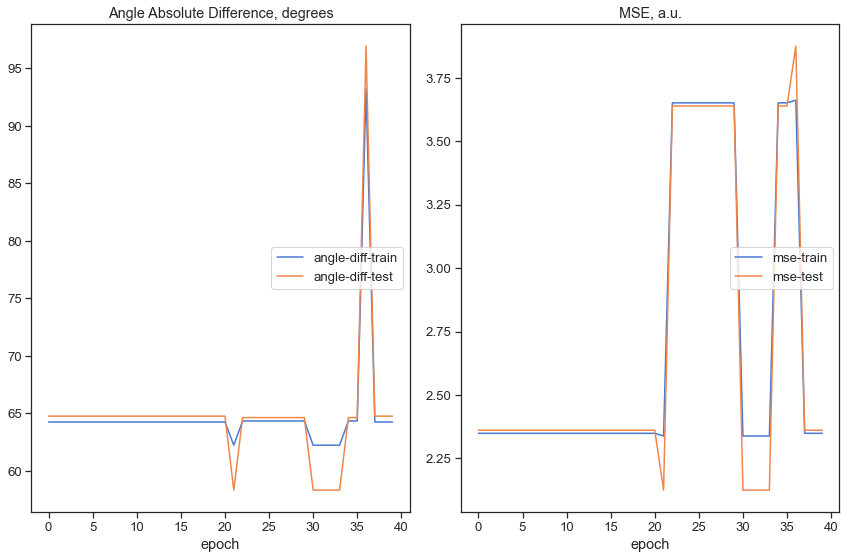

Epochs: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [16:56<00:00, 25.42s/it]


In [24]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

args = {'n_epochs': 40,
        'batch_size': 16,
        'device': set_device(), 
        'lr': 5e-3, 
        'momentum': 0.9, 
        'weight_decay': 1e-9, 
        'lambda_l1': 1e-7, 
        'lambda_l2': 1e-7}

model = EcogUNet(n_chan, n_freqs, n_times).float().to(DEVICE)

trained_model = run_nn(args, 
                       model, 
                       X_train_lodo, 
                       X_test_lodo, 
                       y_train_lodo, 
                       y_test_lodo, 
                       [MatplotlibPlot()], 
                       run_id="07-lodo", 
                       save_frequency=5)

In [71]:
train_loader = DataLoader(list(zip(X_train_lodo, y_train_lodo)), 
                                   batch_size=1, 
                                   shuffle=True)

test_loader  = DataLoader(list(zip(X_test_lodo, y_test_lodo)), 
                                   batch_size=1,
                                   shuffle=True)

In [24]:
test_nn(args, model, test_loader, F.mse_loss)

(tensor(0.8595, device='cuda:0'), tensor(47.5813, device='cuda:0'))

In [49]:
model = trained_model

In [79]:
trained_model.eval()
for batch, (X, y) in enumerate(train_loader):
    print("Batch #", batch)
    X, y = X.to(DEVICE), y.to(DEVICE)
    trained_model.to(DEVICE)

    angle = y / 180 * np.pi
    label = torch.cat((torch.sin(angle).unsqueeze(1), torch.cos(angle).unsqueeze(1)), dim=1)
    prediction = model(X)
    predicted_angle = torch.atan2(prediction[:, 0], prediction[:, 1])
    print("Angle:           ", y)
    print("Predicted angle: ", predicted_angle / np.pi * 180)
    print("Label sin, cos:      ", label)
    print("Prediction sin, cos: ", prediction)
    print("MSE: ", F.mse_loss(prediction, label))
    print()
    
    if batch > 10:
        break

Batch # 0
Angle:            tensor([-134.2496], device='cuda:0')
Predicted angle:  tensor([-88.6376], device='cuda:0', grad_fn=<MulBackward0>)
Label sin, cos:       tensor([[-0.7163, -0.6978]], device='cuda:0')
Prediction sin, cos:  tensor([[-0.5902,  0.0140]], device='cuda:0', grad_fn=<HardtanhBackward0>)
MSE:  tensor(0.2613, device='cuda:0', grad_fn=<MseLossBackward0>)

Batch # 1
Angle:            tensor([-64.5895], device='cuda:0')
Predicted angle:  tensor([-85.2268], device='cuda:0', grad_fn=<MulBackward0>)
Label sin, cos:       tensor([[-0.9033,  0.4291]], device='cuda:0')
Prediction sin, cos:  tensor([[-0.5013,  0.0419]], device='cuda:0', grad_fn=<HardtanhBackward0>)
MSE:  tensor(0.1558, device='cuda:0', grad_fn=<MseLossBackward0>)

Batch # 2
Angle:            tensor([-59.1982], device='cuda:0')
Predicted angle:  tensor([-85.4558], device='cuda:0', grad_fn=<MulBackward0>)
Label sin, cos:       tensor([[-0.8589,  0.5121]], device='cuda:0')
Prediction sin, cos:  tensor([[-0.5012,  

### Debugging

In [ ]:
args = {'n_epochs': 2,
        'batch_size': 8,
        'device': 'cpu', 
        'lr': 1e-3, 
        'momentum': 0.9, 
        'lambda_l1': 0.001, 
        'lambda_l2': 0.005}

#model = EcogUNet(n_chan, n_freqs, n_times).float().to(args['device'])

train_loader = DataLoader(list(zip(X_train_lodo, y_train_lodo)), batch_size=4, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=args['lr'])
    
def criterion(_input, _target, reduction='mean'):
    res = 1 - torch.cos(_input - _target)
    if reduction == 'mean':
        return res.mean()
    if reduction == 'sum':
        return res.sum()

model.to(device)
model.train()

for batch_idx, (X, y) in enumerate(train_loader):
    verbose = batch_idx < 10
    if verbose: print(f"Batch #{batch_idx}")
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()

    sin, cos = model(X)
    if verbose: print(f"Model outputs: \nsin   = {sin.squeeze()}; \ncos   = {cos.squeeze()}")
    angle = torch.atan2(sin, cos)
    if verbose: print(f"Predicted angle: {angle.squeeze() / np.pi}")
    if verbose: print(f"True angle     : {y.squeeze()}")
    loss = criterion(angle.squeeze(), y / 180)
    if verbose: print(f"Loss: {loss.squeeze():.3f} \n")

    loss.backward()
    optimizer.step()

## Model predicting angle.

One output, HardTanh (-1, 1) -> (-pi, pi) angle -> cosine loss

### Architecture

In [11]:
class EcogUNet(nn.Module):
    
    def __init__(self, n_channels, n_freqs, n_times, bilinear=False):
        super(EcogUNet, self).__init__()
        self.n_channels = n_channels
        self.n_freqs = n_freqs
        self.n_times = n_times
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1

        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
        # at this point we have vector of shape (batch_size, 64, n_freqs, n_times)
        
        # reduce the shape of input by // 2 and channels by 2
        self.down5 = Down(64, 32)
        
        self.flatten = nn.Flatten()
        
        # get shape (batch_size, 32 * n_freqs // 2 * n_times // 2)
        
        self.fc1 = nn.Linear(32 * (n_freqs // 2) * (n_times // 2), 512)
        self.act1 = nn.SiLU()
        self.dropout = nn.Dropout(p=0.3)
        
        self.fc2 = nn.Linear(512, 128)
        self.act2 = nn.SiLU()
        self.batchnorm = nn.BatchNorm1d(128)
        
        self.output = nn.Linear(128, 1)
        self.out_act = nn.Hardtanh(-1., 1.)
           

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        x = self.up2(x4, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        # returned to original shape and 64 channels
        x = self.down5(x)
        x = self.flatten(x)
        # FC 1 
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout(x)
        # FC 2
        x = self.fc2(x)
        x = self.act2(x)
        x = self.batchnorm(x)
        # output layer [-1, 1]
        x = self.output(x)
        # get angle in rad
        out = np.pi * self.out_act(x)
        return out


In [12]:
summary(EcogUNet(n_chan, n_freqs, n_times).to(DEVICE), (n_chan, n_freqs, n_times))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 25, 30]           4,608
       BatchNorm2d-2           [-1, 64, 25, 30]             128
              ReLU-3           [-1, 64, 25, 30]               0
            Conv2d-4           [-1, 64, 25, 30]          36,864
       BatchNorm2d-5           [-1, 64, 25, 30]             128
              ReLU-6           [-1, 64, 25, 30]               0
        DoubleConv-7           [-1, 64, 25, 30]               0
         MaxPool2d-8           [-1, 64, 12, 15]               0
            Conv2d-9          [-1, 128, 12, 15]          73,728
      BatchNorm2d-10          [-1, 128, 12, 15]             256
             ReLU-11          [-1, 128, 12, 15]               0
           Conv2d-12          [-1, 128, 12, 15]         147,456
      BatchNorm2d-13          [-1, 128, 12, 15]             256
             ReLU-14          [-1, 128,

### Defining train, test and run funcs

In [36]:
def train_nn(args, model, train_loader, optimizer, criterion):
    """
    Traines the model for one epoch
    Returns the trained model
    
    """
    device = args['device']
    
    model.train()
    model.to(device)
    
    for batch_idx, (X, y) in enumerate(train_loader):
        
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        # criterion is MSE loss, however it is done on sin and cos of real angle!!!!
        angle = y / 180 * np.pi
        target = angle
        prediction = model(X).squeeze()
    
        loss = criterion(prediction, target).mean()
        
        # regularization
        if args['lambda_l1'] != 0:
            l1_loss = sum([torch.sum(torch.abs(p)) for p in model.parameters()])
            loss = loss + args['lambda_l1'] * l1_loss
        if args['lambda_l2'] != 0:
            l2_loss = sum([torch.sum(p.pow(2)) for p in model.parameters()])
            loss = loss + args['lambda_l2'] * l2_loss

        loss.backward()
        optimizer.step()
        
    return model


def test_nn(args, model, test_loader, criterion):
    """
    Calculates one epoch loss and accuracy
    
    """
    device = args['device']
    
    model.eval()
    model.to(device)
    
    loss = 0
    angle_loss = 0
    
    with torch.no_grad():
        for X, y in test_loader:
            
            X, y = X.to(device), y.to(device)
            
            angle = y / 180 * np.pi
            target = angle
            prediction = model(X).squeeze()
            
            assert prediction.shape == target.shape
            loss += criterion(prediction, target).sum()
            
            # mean absolute deviation in degrees
            angle_loss += torch.sum((torch.abs(prediction - target) / np.pi * 180) % 180)
            
            
        # acquire per-sample loss    
        loss /= len(test_loader.dataset)
        angle_loss /= len(test_loader.dataset)
        
         
    return loss, angle_loss
    
    
def run_nn(args, model, X_train, X_test, y_train, y_test, outputs_liveloss=[MatplotlibPlot()], run_id='01', save_frequency=5):
    """
    Trains the model with train_loader and
    tests the learned model using val_loader

    Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Train dataset
    test_loader: torch.loader
      Validation set

    Returns:
    test_acc_list: list
      Log of validation accuracy
    train_acc_list: list
      Log of training accuracy
    trained_model: nn.module
      Trained model/model post training
    """
    
    # create DataLoaders
    train_loader = DataLoader(list(zip(X_train, y_train)), 
                                   batch_size=args['batch_size'], 
                                   shuffle=True)

    test_loader  = DataLoader(list(zip(X_test, y_test)), 
                                   batch_size=args['batch_size'],
                                   shuffle=True)

    print(f" X_train: {X_train.shape} \n X_test:  {X_test.shape} \n y_train: {y_train.shape} \n y_test:  {y_test.shape} ")

    device = args['device']
    model = model.to(device)
    
    # may tune it to RMSprop as in original github
    #optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
    optimizer = optim.RMSprop(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'], momentum=args['momentum'])
    
    # from stackoverflow: 0.5 (sin(angle) - sin_hat)**2 + (cos(angle) - cos_hat) ** 2) = MSE!!!
    def criterion(prediction, target):
        assert prediction.shape == target.shape
        # reduction to be made in train and test funcs
        return 1 - torch.cos(prediction - target)

        
    # for live loss update plotting
    groups = {'Cosine loss, a.u.': ['cos-train', 'cos-test'], 'Angle Absolute Difference, degrees': ['angle-diff-train', 'angle-diff-test']}
    plotlosses = PlotLosses(groups=groups, outputs=outputs_liveloss)
    
    # initialize loss containers
    train_mse_loss_list, test_mse_loss_list, train_angle_loss_list, test_angle_loss_list = [], [], [], []
    trained_model = model
    

    # main training loop
    for epoch in tqdm(range(args['n_epochs']), desc='Epochs'):
        
        # train for one epoch
        trained_model = train_nn(args, model, train_loader, optimizer, criterion)
        
        # acquire train and test (eval) loss values
        train_mse_loss, train_angle_loss = test_nn(args, trained_model, train_loader, criterion)
        test_mse_loss, test_angle_loss   = test_nn(args, trained_model, test_loader, criterion)

        # update loss containers
        train_mse_loss_list.append(train_mse_loss.cpu().detach()) 
        test_mse_loss_list.append(test_mse_loss.cpu().detach())
        train_angle_loss_list.append(train_angle_loss.cpu().detach())
        test_angle_loss_list.append(test_angle_loss.cpu().detach())

        # plotting live plot
        plotlosses.update({
            'cos-train': train_mse_loss.cpu().detach(),
            'cos-test': test_mse_loss.cpu().detach(),
            'angle-diff-train': train_angle_loss.cpu().detach(),
            'angle-diff-test': test_angle_loss.cpu().detach()
        })
        plotlosses.send()
        time.sleep(.01)

        # saving the model
        try:
            os.mkdir(os.path.join(os.getcwd(), "checkpoints"))
        except:
            pass

        if (save_frequency > 0):
            if epoch % save_frequency == 0:
                fpath = os.path.join(os.getcwd(), "checkpoints", f"ecogunet_run-{run_id}_epoch-{epoch}.pt")
                with open(fpath, 'wb') as file:
                    torch.save(trained_model.cpu().state_dict(), file)
                trained_model.cuda()

        
    # record model performance to access it later
    trained_model._performance = {
            'loss-train': train_mse_loss_list,
            'loss-test': test_mse_loss_list,
            'angle-diff-train': train_angle_loss_list,
            'angle-diff-test': test_angle_loss_list
        }
    
    # на всякий случай
    trained_model.eval()

    return trained_model

### Run

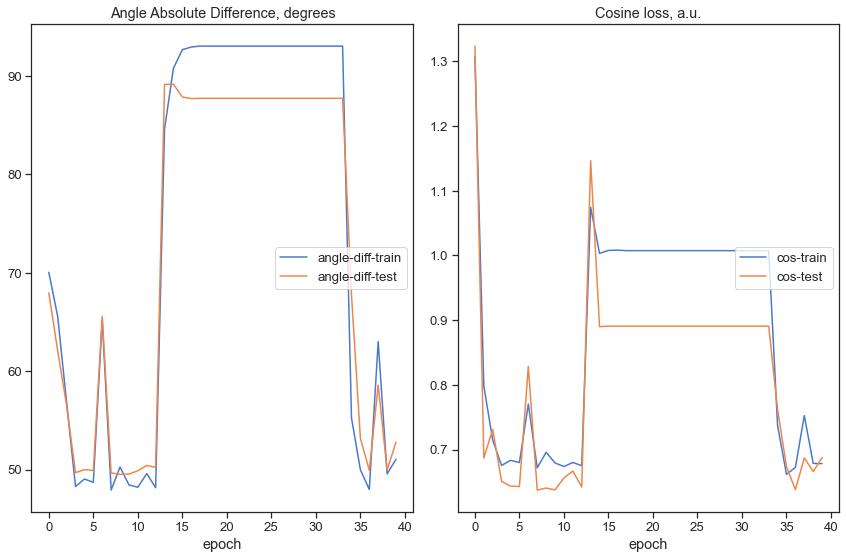

Epochs: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [10:19<00:00, 15.50s/it]


In [37]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

args = {'n_epochs': 40,
        'batch_size': 32,
        'device': set_device(), 
        'lr': 1.5e-3, 
        'momentum': 0.9, 
        'weight_decay': 1e-9, 
        'lambda_l1': 1e-7, 
        'lambda_l2': 0}

model = EcogUNet(n_chan, n_freqs, n_times).float().to(DEVICE)

trained_model = run_nn(args, 
                       model, 
                       X_train_loso, 
                       X_test_loso, 
                       y_train_loso, 
                       y_test_loso, 
                       [MatplotlibPlot()], 
                       run_id="06-lodo-cos", 
                       save_frequency=5)

### Debug

In [30]:
args = {'n_epochs': 2,
        'batch_size': 32,
        'device': set_device(), 
        'lr': 1.5e-3, 
        'momentum': 0.9, 
        'weight_decay': 1e-9, 
        'lambda_l1': 1e-7, 
        'lambda_l2': 0}


#model = EcogUNet(n_chan, n_freqs, n_times).float().to(args['device'])

train_loader = DataLoader(list(zip(X_train_lodo, y_train_lodo)), batch_size=4, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=args['lr'])
    
def criterion(prediction, target):
    assert prediction.shape == target.shape
    return 1 - torch.cos(prediction - target)   # reduction to be made in train and test funcs

device = args['device']
model.to(device)
model.train()

for batch_idx, (X, y) in enumerate(train_loader):
    verbose = batch_idx < 10
    if verbose: print(f"Batch #{batch_idx}")
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    
    prediction = model(X)
    if verbose: print(f"Model outputs: {prediction.squeeze()}")
    if verbose: print(f"True angle     : {y / 180 * np.pi}")
    loss = criterion(prediction.squeeze(), y / 180 * np.pi).mean()
    if verbose: print(f"Loss: {loss} \n")

    loss.backward()
    optimizer.step()

GPU is enabled in this notebook.
Batch #0
Model outputs: tensor([ 3.1416,  3.1416,  3.1416, -3.1416], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
True angle     : tensor([ 1.9624,  0.9354,  1.1772, -1.8486], device='cuda:0')
Loss: 1.0802812576293945 

Batch #1
Model outputs: tensor([ 3.1416,  3.1416, -3.1416,  3.1416], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
True angle     : tensor([-1.3640,  1.0486,  1.1418,  0.3557], device='cuda:0')
Loss: 1.5143516063690186 

Batch #2
Model outputs: tensor([ 3.1416,  3.1416,  3.1416, -3.1416], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
True angle     : tensor([ 0.8518, -2.1390,  1.4163, -1.5584], device='cuda:0')
Loss: 1.071690559387207 

Batch #3
Model outputs: tensor([ 3.1416, -3.1416,  3.1416,  3.1416], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
True angle     : tensor([-2.6588, -0.7536, -1.6128,  1.9279], device='cuda:0')
Loss: 0.8630106449127197 

Batch #4
Model outputs: tensor([-3.1416,  3.1416,  3.1416,  

KeyboardInterrupt: 

NameError: name 'y' is not defined

In [ ]:
np.arccos(0.8) * 180

In [ ]:
summary()

In [ ]:
plt.plot(train_loss_list)
plt.plot(test_loss_list)

In [ ]:
train_loss_list

In [ ]:
F.mse_loss(180 * torch.rand(16), torch.ones(16) * 100)

0